In [879]:
include("SchwarzChristoffel.jl")

SchwarzChristoffel

In [880]:
p = SchwarzChristoffel.Polygon([-1.0,0.2,1.0,-1.0],[-1.0,-1.0,0.5,1.0])

Polygon with 4 vertices at Complex{Float64}[-1.0-1.0im, 0.2-1.0im, 1.0+0.5im, -1.0+1.0im] 
             interior angles/π = [0.5, 0.656, 0.422, 0.422]


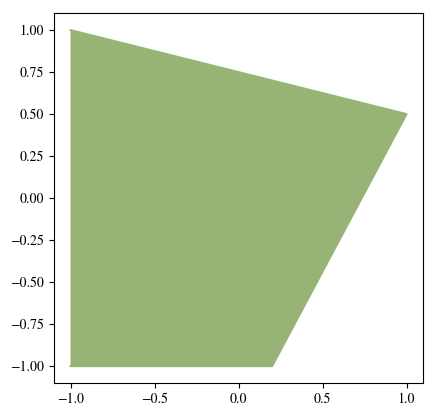

(-1.1, 1.1, -1.1, 1.1)

In [881]:
SchwarzChristoffel.plot(p)

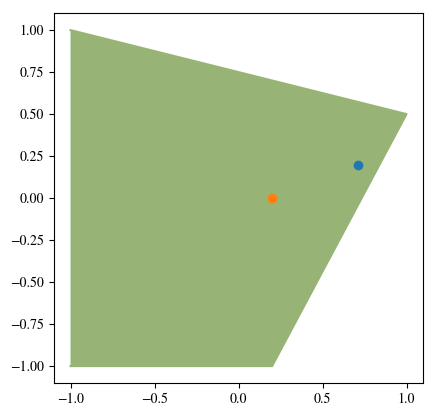

1×2 BitArray{2}:
 true  true

In [882]:
z = [0.71+im*0.2 0.2+im*0]
SchwarzChristoffel.Polygons.plot(p)
PyPlot.plot(real.(z),imag.(z),marker="o")
SchwarzChristoffel.isinpoly.(z,p,1e-5)

In [883]:
z1 = -1.0+0.0im #1.0im
z2 = exp(im*5π/4) #exp(im*3π/4)
sing1 = 2 #1
beta = [0.5,0.5,0.5,0.5]
z = [1.0im,-1.0,-1.0im,1.0]
nqpts = 8
qdat = SchwarzChristoffel.Integration.qdata(beta,nqpts)
dquad = SchwarzChristoffel.Exterior.DQuad(z,beta,qdat)
dabsquad2 = SchwarzChristoffel.Exterior.DabsQuad(z,beta,qdat)
I = dabsquad2(z1,z2,sing1)

0.8472130847939816

In [884]:
z1 = [-1.0+0.0im,0.0+1.0im]
z2 = [exp(im*5π/4),exp(im*3π/4)]
sing1 = [2,1]
I = dquad.(z1,z2,sing1)

2-element Array{Complex{Float64},1}:
 -0.59907-0.59907im
  0.59907-0.59907im

In [885]:
map = SchwarzChristoffel.ExteriorMap(p)

Exterior map with 4 vertices at
       -1.0 - 1.0im
       0.2 - 1.0im
       1.0 + 0.5im
       -1.0 + 1.0im
   interior angles/π at
       0.5
       0.656
       0.422
       0.422
   prevertices on circle at
       1.0 + 0.0im
       0.3764 - 0.9265im
       -0.9024 - 0.4309im
       -0.1868 + 0.9824im
   constant = 0.6722 + 0.7669im
   accuracy = 1.0e-8


In [886]:
prev, C = SchwarzChristoffel.parameters(map)

(Complex{Float64}[-0.186756+0.982406im, -0.902383-0.430935im, 0.376406-0.926455im, 1.0+0.0im], 0.6722109863402015 + 0.7668866078562682im)

In [887]:
zeta = [0.1,0.5-0.75im,-0.25-0.3im]
SchwarzChristoffel.evaluate(zeta,map)

3-element Array{Complex{Float64},1}:
   -6.9344-7.68965im 
 0.0439774-1.11249im 
   2.41181-0.044779im